In [1996]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [1997]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [1998]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
# Fill missing values in 'age' with the average age
titanic.fillna({'age': titanic['age'].mean()}, inplace=True)


# Discretization
titanic['age'] = QuantileBinning(titanic['age'], 10)

features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'
encoder = ce.OrdinalEncoder(cols=features)
print(encoder)

# make sure feature and target are not null
print(titanic.isnull().sum())

# Split the data into 80% training and 20% test sets
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)
train = encoder.fit_transform(titanic[['pclass', 'sex', 'age', 'sibsp', 'survived']])

OrdinalEncoder(cols=['pclass', 'sex', 'age', 'sibsp'])
Unnamed: 0       0
pclass           0
survived         0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             1
cabin         1014
embarked         2
boat           823
body          1188
home.dest      564
dtype: int64


In [1999]:
X_train.head()

,pclass,sex,age,sibsp
1037,1,1,1,1
113,2,1,2,2
870,1,1,3,1
526,3,2,1,1
1128,1,2,1,1


In [2000]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1047, 4), (262, 4), (1047,), (262,))

In [2001]:
X_train.dtypes, X_test.dtypes, y_train.dtypes, y_test.dtypes

(pclass    int64
 sex       int64
 age       int64
 sibsp     int64
 dtype: object,
 pclass    int64
 sex       int64
 age       int64
 sibsp     int64
 dtype: object,
 dtype('int64'),
 dtype('int64'))

# Step 2

In [2002]:
# https://www.youtube.com/watch?v=F00X97p5DfI

In [2003]:
# define your entropy function and information gain function
from math import log2


def entropy(y):
    """Calculate the entropy of the label distribution."""
    probs = y.value_counts(normalize=True)
    return -sum([p * log2(p) for p in probs if p > 0])


def information_gain(data, split_feature, target):
    """Calculate information gain of a feature."""
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[split_feature], return_counts=True)

    weighted_entropy = 0
    for i, value in enumerate(values):
        subset = data[data[split_feature] == value]
        subset_entropy = entropy(subset[target])

        weight = counts[i] / len(data)
        weighted_entropy += weight * subset_entropy

    info_gains = total_entropy - weighted_entropy
    return info_gains


for feature in features:
    gain = information_gain(train, feature, target)
    print(f"Information Gain {feature}: {gain}")

Information Gain pclass: 0.0704074128460409
Information Gain sex: 0.2055048727200759
Information Gain age: 0.018607530828718133
Information Gain sibsp: 0.026983534163970146


So the first split should be "sex"

# Step 3

In [2004]:
from sklearn.tree import DecisionTreeClassifier

student_id = 20035085

# Instantiate the DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(
    criterion='gini', max_depth=3, random_state=student_id)

features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'

# Fit the decision tree model
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


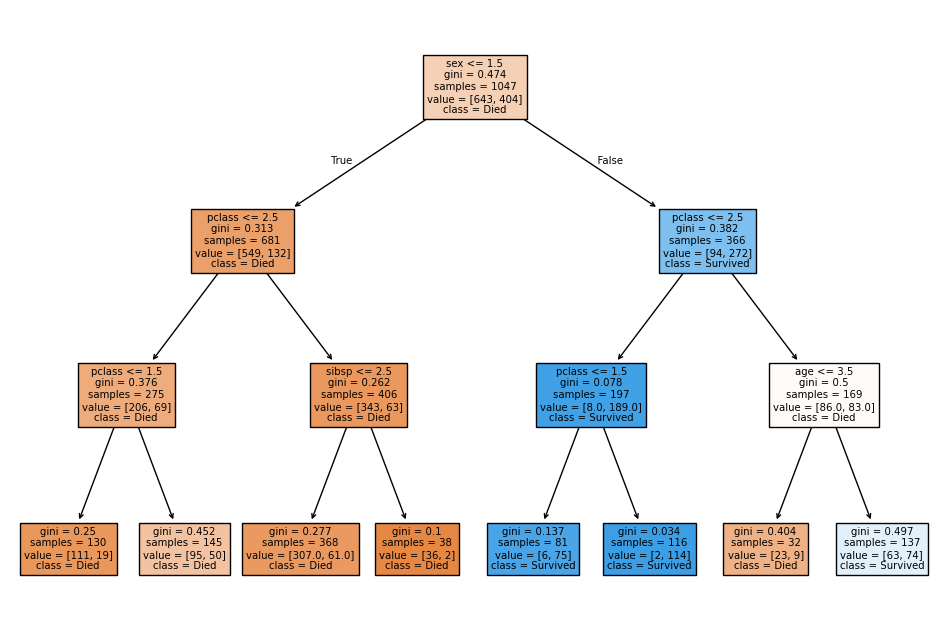

In [2005]:
# Plot the full decision tree
from sklearn import tree

plt.figure(figsize=(12, 8))

tree.plot_tree(clf_gini.fit(X_train, y_train), feature_names=features,
               class_names=["Died", "Survived"],  filled=True)
plt.show()

In [2006]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
from sklearn.metrics import accuracy_score

y_pred_gini = clf_gini.predict(X_test)
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))


Model accuracy score with criterion gini index: 0.7481


In [2007]:
y_pred_train_gini = clf_gini.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.7975


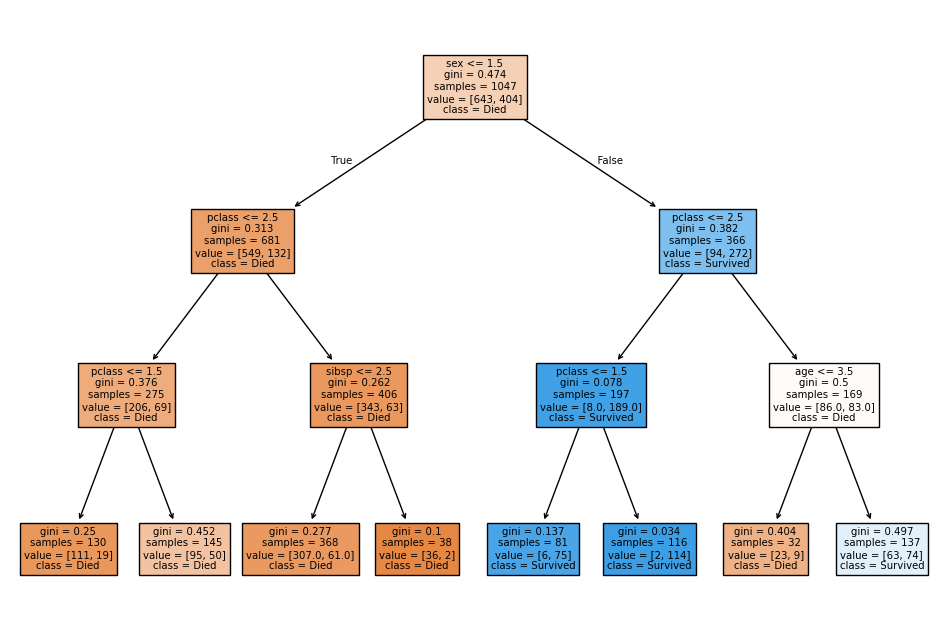

Accuracy: 0.7481
Precision: 0.6596
Recall: 0.6458
F1 Score: 0.6526


In [2008]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

student_id = 20035085

# Instantiate the DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=student_id)

# Fit the decision tree model
clf_gini.fit(X_train, y_train)

# Plot the full decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf_gini, feature_names=features, class_names=["Died", "Survived"], filled=True)
plt.show()

# Calculate accuracy, precision, recall, and F1 score for the test set
y_pred_gini = clf_gini.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_gini)
precision = precision_score(y_test, y_pred_gini)
recall = recall_score(y_test, y_pred_gini)
f1 = f1_score(y_test, y_pred_gini)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


# Step 4

Best tree parameters: {'max_leaf_nodes': 11}


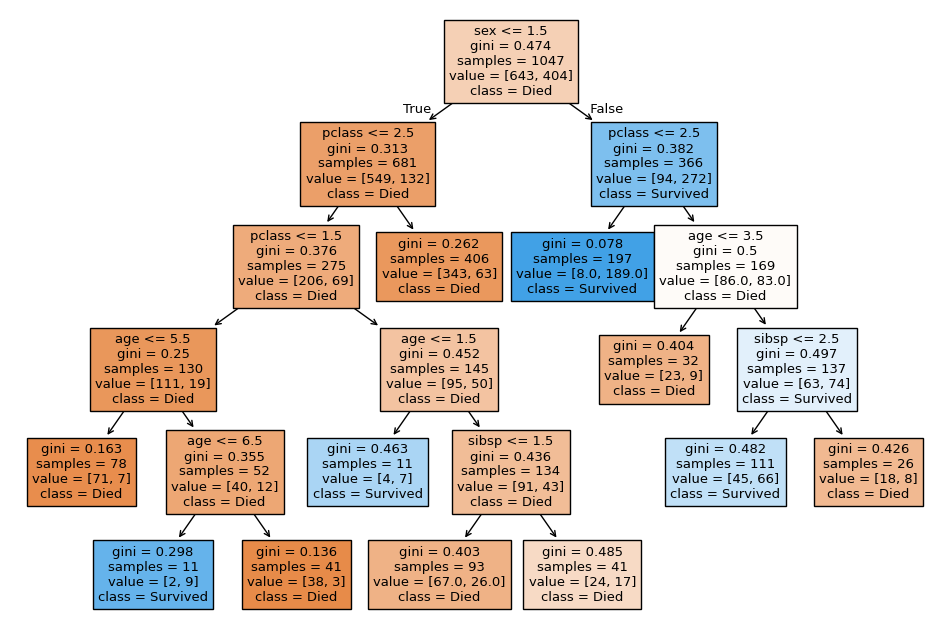

Accuracy (Pruned Tree): 0.7061
Precision (Pruned Tree): 0.5905
Recall (Pruned Tree): 0.6458
F1 Score (Pruned Tree): 0.6169


In [2009]:
# Step 4: Grid Search for Pruning the Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=student_id), param_grid, cv=5)
grid_search.fit(X_train, y_train)  # Fit only on training set

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_
print(f"Best tree parameters: {grid_search.best_params_}")

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_tree, feature_names=features, class_names=["Died", "Survived"], filled=True)
plt.show()

# Evaluate the performance of the pruned tree
y_pred_best_tree = best_tree.predict(X_test)
accuracy_best_tree = accuracy_score(y_test, y_pred_best_tree)
precision_best_tree = precision_score(y_test, y_pred_best_tree)
recall_best_tree = recall_score(y_test, y_pred_best_tree)
f1_best_tree = f1_score(y_test, y_pred_best_tree)

print(f'Accuracy (Pruned Tree): {accuracy_best_tree:.4f}')
print(f'Precision (Pruned Tree): {precision_best_tree:.4f}')
print(f'Recall (Pruned Tree): {recall_best_tree:.4f}')
print(f'F1 Score (Pruned Tree): {f1_best_tree:.4f}')

# Step 5


In [2010]:
## it's an example (max_depth)

In [2011]:
# https://medium.com/@jwbtmf/decision-tree-and-ensemble-learning-algorithms-in-machine-learning-ea27b4429d85
# Step 5: Implement Ensemble Voting
from scipy.stats import mode

def ensemble_vote(models, X):
    """
    Perform majority voting for an ensemble of models.

    Parameters:
    - models (list): List of trained models.
    - X (pandas.DataFrame): Feature set for prediction.

    Returns:
    - np.array: Predictions based on majority voting.
    """
    # Collect predictions from all models
    predictions = np.array([model.predict(X) for model in models])
    # Perform majority vote (row-wise mode across predictions)
    ensemble_predictions = mode(predictions, axis=0).mode[0]
    return predictions


# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, clf_gini, DecisionTreeClassifier(
    criterion='entropy', random_state=student_id).fit(X_train, y_train)]
ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using accuracy
for prediction in ensemble_predictions:
    ensemble_accuracy = accuracy_score(y_test, prediction)
    print(f'Ensemble model accuracy: {ensemble_accuracy:.4f}')

Ensemble model accuracy: 0.7061
Ensemble model accuracy: 0.7481
Ensemble model accuracy: 0.6412


In [2012]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 